In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
my_palette = {"healthy":sns.color_palette("Set2")[4], "UC":sns.color_palette("Set2")[5],"IBD":sns.color_palette("Set2")[1],"CD":sns.color_palette("Accent")[6]}
palette = sns.color_palette("hls", 8)
from statannot import add_stat_annotation

In [2]:
params = pd.read_csv("Data/calculated_parameters_for_merged.txt", sep="\t", index_col=1).iloc[:,1:]
print(params.head())

                GMHI_good  GMHI_bad  Frac_of_core_functions_among_all  \
Sample                                                                  
MMPD54490160ST          1         0                          0.607143   
MMPD37460080ST          0         4                          0.620370   
MMPD56131850ST          1         0                          0.706897   
MMPD19623701ST          1         1                          0.619403   
MMPD91893113ST          1         3                          0.559524   

                Frac_of_core_functions_found  Species_found_together  \
Sample                                                                 
MMPD54490160ST                      0.100592                0.219512   
MMPD37460080ST                      0.396450                0.000000   
MMPD56131850ST                      0.242604                0.414634   
MMPD19623701ST                      0.491124                0.512195   
MMPD91893113ST                      0.556213            

In [3]:
meta = pd.read_csv("Data/merged_metadata.txt", sep="\t", index_col=0)
for a in list(set(list(meta['cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        meta = meta.loc[meta['cohort'] != a]
print(meta.head())
print(meta.shape)

                  category       cohort
sample                                 
SKST027_1_G102984      IBD  HallAB_2017
SKST032_1_G102943      IBD  HallAB_2017
SKST023_1_G102981  healthy  HallAB_2017
SKST011_1_G102971  healthy  HallAB_2017
SKST024_1_G102982  healthy  HallAB_2017
(279, 2)


In [4]:
merged = pd.merge(params, meta['category'].to_frame(), left_index=True, right_index=True)
merged = merged.replace('healthy',1)
merged = merged.replace('IBD',0)
merged = merged.replace('UC',0)
merged = merged.replace('CD',0)

print(merged.head())

                   GMHI_good  GMHI_bad  Frac_of_core_functions_among_all  \
SKST027_1_G102984          0         1                          0.620690   
SKST032_1_G102943          0         2                          0.484163   
SKST023_1_G102981          0         3                          0.602649   
SKST011_1_G102971          0         8                          0.538462   
SKST024_1_G102982          0         5                          0.601266   

                   Frac_of_core_functions_found  Species_found_together  \
SKST027_1_G102984                      0.426036                0.146341   
SKST032_1_G102943                      0.633136                0.048780   
SKST023_1_G102981                      0.538462                0.365854   
SKST011_1_G102971                      0.621302                0.365854   
SKST024_1_G102982                      0.562130                0.243902   

                   Contributions_per_species  category  
SKST027_1_G102984                  

In [5]:
# Function to run Random Forest with Leave-One-Out Cross Validation

def run_random_forest_loocv(df, target_col):
    # Splitting the DataFrame into features and labels
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Initialize the Leave-One-Out cross-validator
    loo = LeaveOneOut()
    
    # Store results
    results = []
    all_predicted_probs = []
    all_actual_labels = []
    
    # Assuming the sample names are in the index of the DataFrame
    sample_names = X.index.tolist()  # Get sample names from the index
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train Random Forest model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predict probabilities for the test sample
        if len(np.unique(y_train)) > 1:  # Check if both classes are present in the training set
            y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
        else:
            # Assign the predicted probability based on the actual label
            y_pred_prob = np.array([1.0 if y_test.values[0] == 1 else 0.0])
        
        # Store results for the test sample
        results.append({
            'sample_name': sample_names[test_idx[0]],  # Use the sample name from the list
            'predicted_probability': y_pred_prob[0],
            'actual_label': y_test.values[0]
        })
        
        # Append to lists for overall AUC and accuracy calculation
        all_predicted_probs.append(y_pred_prob[0])
        all_actual_labels.append(y_test.values[0])
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_actual_labels, (np.array(all_predicted_probs) >= 0.5).astype(int))
    
    # Calculate AUC
    auc = roc_auc_score(all_actual_labels, all_predicted_probs)
    
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    print(f'AUC: {auc:.4f}')
    
    return results_df

# Main:
# Assuming 'merged' is your DataFrame and 'category' is your target column
predictions_df = run_random_forest_loocv(merged, target_col='category')

# Display the predictions DataFrame
print(predictions_df)

Overall Accuracy: 0.6426
AUC: 0.6555
           sample_name  predicted_probability  actual_label
0    SKST027_1_G102984                   0.38             0
1    SKST032_1_G102943                   0.22             0
2    SKST023_1_G102981                   0.74             1
3    SKST011_1_G102971                   0.37             1
4    SKST024_1_G102982                   0.38             1
..                 ...                    ...           ...
272          V1_UC61_0                   0.12             1
273          V1_UC62_0                   0.23             1
274           V1_UC7_0                   0.79             1
275           V1_UC8_0                   0.35             1
276           V1_UC9_0                   0.45             1

[277 rows x 3 columns]


In [6]:
final_df = pd.merge(meta, predictions_df, left_index=True, right_on='sample_name')

print(final_df.head())

  category       cohort        sample_name  predicted_probability  \
0      IBD  HallAB_2017  SKST027_1_G102984                   0.38   
1      IBD  HallAB_2017  SKST032_1_G102943                   0.22   
2  healthy  HallAB_2017  SKST023_1_G102981                   0.74   
3  healthy  HallAB_2017  SKST011_1_G102971                   0.37   
4  healthy  HallAB_2017  SKST024_1_G102982                   0.38   

   actual_label  
0             0  
1             0  
2             1  
3             1  
4             1  


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

HallAB_2017_healthy v.s. HallAB_2017_IBD: t-test independent samples with Bonferroni correction, P_val=5.539e-01 stat=1.535e+00
NielsenHB_2014_healthy v.s. NielsenHB_2014_IBD: t-test independent samples with Bonferroni correction, P_val=3.176e-02 stat=2.680e+00
HMP2_IBD_UC v.s. HMP2_IBD_healthy: t-test independent samples with Bonferroni correction, P_val=6.608e-02 stat=-2.586e+00
HMP2_IBD_CD v.s. HMP2_IBD_healthy: t-test independent samples with Bonferroni correction, P_val=1.501e-03 stat=-4.042e+00


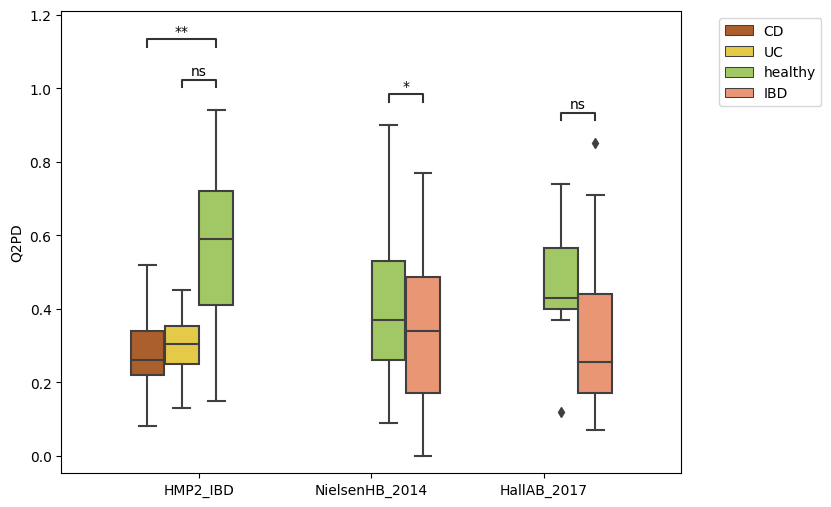

In [7]:
pairs = [
    (('HMP2_IBD', 'healthy'), ('HMP2_IBD', 'UC')),
    (('HMP2_IBD', 'healthy'), ('HMP2_IBD', 'CD')),
    (('NielsenHB_2014', 'healthy'), ('NielsenHB_2014', 'IBD')),
    (('HallAB_2017', 'healthy'), ('HallAB_2017', 'IBD'))]

plt.figure(figsize=(8,6))
ax = sns.boxplot(final_df.sort_values(by='sample_name'), x='cohort',y='predicted_probability', hue='category', palette=my_palette)
plt.xlabel("")
plt.ylabel("Q2PD")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
add_stat_annotation(
    ax, 
    data=final_df.sort_values(by='sample_name'), 
    x='cohort', 
    y='predicted_probability', 
    hue='category', 
    box_pairs=pairs, 
    test='t-test_ind', 
    text_format='star', 
    loc='inside', 
    verbose=2
)
plt.show()

In [8]:
final_df['predicted_label'] = (np.array(list(final_df['predicted_probability'])) >= 0.5).astype(int)

def calculate_metrics_by_cohort(final_df):
    # Initialize an empty list to store results
    results = []
    
    # Group by 'cohort'
    grouped = final_df.groupby('cohort')
    
    for cohort_name, group in grouped:
        # Calculate accuracy
        accuracy = accuracy_score(group['actual_label'], group['predicted_label'])
        
        # Calculate AUC; ensure that we only calculate AUC if there are both classes present
        if len(group['actual_label'].unique()) == 2:
            auc = roc_auc_score(group['actual_label'], group['predicted_label'])
        else:
            auc = None  # Not calculable if one class is missing
        
        # Store the results
        results.append({
            'cohort': cohort_name,
            'accuracy': accuracy,
            'AUC': auc
        })
    
    # Convert results to DataFrame
    metrics_df = pd.DataFrame(results)
    
    return metrics_df

# Main:
# Assuming 'final_df' is your DataFrame containing the necessary columns
metrics_df = calculate_metrics_by_cohort(final_df)
metrics_df['Method'] = "Q2PD"
metrics_df.columns = ['Cohort','Accuracy','AUC','Method']
# Display the metrics DataFrame
print(metrics_df)

           Cohort  Accuracy       AUC Method
0        HMP2_IBD  0.764706  0.794872   Q2PD
1     HallAB_2017  0.640000  0.620130   Q2PD
2  NielsenHB_2014  0.623853  0.542685   Q2PD


In [9]:
### Comparing other tools

scores = pd.read_csv("Data/metadata_and_index_values.txt", sep="\t", index_col=0)
binary_label = []
for a in list(scores['category']):
    if a == "healthy":
        binary_label.append(1)
    else:
        binary_label.append(0)
scores['binary'] = binary_label
print(scores)

                                                  category            cohort  \
ID                                                                             
HMP2_J15237_M_ST_T0_B0_0120_ZW61YGW-01_BHLVVGADXX      IGT      HMP_2019_t2d   
ESS-0531                                            ME/CFS  NagySzakalD_2017   
S312                                                   IGT   KarlssonFH_2013   
HD-58                                              healthy         QinN_2014   
SAMD00114738                                           CRC     YachidaS_2019   
...                                                    ...               ...   
CCIS50148151ST-4-0                                     CRC      ZellerG_2014   
S195                                               healthy   KarlssonFH_2013   
U_VS-1592-367                                      healthy       RosaBA_2018   
SAMEA104142076                                     healthy         JieZ_2017   
CCMD13071240ST-21-0                     

In [10]:
## GMHI 

df = scores.copy()

# Initialize lists to hold cohort names, AUC, and accuracy results
cohorts_list = []
auc_list = []
accuracy_list = []

# Group by cohort and calculate AUC and accuracy for each cohort
for cohort, group in df.groupby('cohort'):
    # Ensure there are at least two classes to compute AUC and accuracy
    if group['binary'].nunique() == 2:
        # Calculate predictions based on GMHI values
        predictions = (group['GMHI'] >= 0).astype(int)  # 1 if GMHI >= 0, else 0
        
        auc = roc_auc_score(group['binary'], predictions)
        accuracy = accuracy_score(group['binary'], predictions)  # Use predictions for accuracy
    else:
        auc = None  # Can't compute AUC if only one class present
        accuracy = None  # Can't compute accuracy if only one class present
    
    # Append results to lists
    cohorts_list.append(cohort)
    auc_list.append(auc)
    accuracy_list.append(accuracy)

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'Cohort': cohorts_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

for a in list(set(list(results_df['Cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        results_df = results_df.loc[results_df['Cohort'] != a]
# Display the results DataFrame
results_df['Method'] = "GMHI"

metrics_df = metrics_df._append(results_df)
print(metrics_df)

            Cohort  Accuracy       AUC Method
0         HMP2_IBD  0.764706  0.794872   Q2PD
1      HallAB_2017  0.640000  0.620130   Q2PD
2   NielsenHB_2014  0.623853  0.542685   Q2PD
4         HMP2_IBD  0.485714  0.559524   GMHI
6      HallAB_2017  0.653846  0.603030   GMHI
14  NielsenHB_2014  0.532110  0.500144   GMHI


In [11]:
## hiPCA

df = scores.copy()

# Initialize lists to hold cohort names, AUC, and accuracy results
cohorts_list = []
auc_list = []
accuracy_list = []

# Group by cohort and calculate AUC and accuracy for each cohort
for cohort, group in df.groupby('cohort'):
    # Ensure there are at least two classes to compute AUC and accuracy
    if group['binary'].nunique() == 2:
        # Calculate predictions based on GMHI values
        predictions = (group['hiPCA'] >= -2).astype(int)  
        
        auc = roc_auc_score(group['binary'], predictions)
        accuracy = accuracy_score(group['binary'], predictions)  # Use predictions for accuracy
    else:
        auc = None  # Can't compute AUC if only one class present
        accuracy = None  # Can't compute accuracy if only one class present
    
    # Append results to lists
    cohorts_list.append(cohort)
    auc_list.append(auc)
    accuracy_list.append(accuracy)

# Create a DataFrame from the lists
results_df = pd.DataFrame({
    'Cohort': cohorts_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list
})

for a in list(set(list(results_df['Cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        results_df = results_df.loc[results_df['Cohort'] != a]
# Display the results DataFrame
results_df['Method'] = "hiPCA"

metrics_df = metrics_df._append(results_df)
print(metrics_df)

            Cohort  Accuracy       AUC Method
0         HMP2_IBD  0.764706  0.794872   Q2PD
1      HallAB_2017  0.640000  0.620130   Q2PD
2   NielsenHB_2014  0.623853  0.542685   Q2PD
4         HMP2_IBD  0.485714  0.559524   GMHI
6      HallAB_2017  0.653846  0.603030   GMHI
14  NielsenHB_2014  0.532110  0.500144   GMHI
4         HMP2_IBD  0.742857  0.690476  hiPCA
6      HallAB_2017  0.692308  0.721212  hiPCA
14  NielsenHB_2014  0.614679  0.626904  hiPCA


In [12]:
### Shannon on taxa

cohort_list = []
accuracy_list = []
auc_list = []
threshold_list = []

# Loop through each cohort
for cohort in list(set(scores['cohort'])):
    
    cohort_data = scores[scores['cohort'] == cohort]
    shannon_entropies = np.array(cohort_data['Shannon Entropy'])
    labels = np.array(cohort_data['binary'])

    loo = LeaveOneOut()
    thresholds = []
    predictions = np.zeros_like(labels)  # Array to store predictions for each sample
    
    # Leave-One-Out Cross-Validation for threshold selection
    for train_idx, test_idx in loo.split(shannon_entropies):
        shannon_train, shannon_test = shannon_entropies[train_idx], shannon_entropies[test_idx]
        label_train, label_test = labels[train_idx], labels[test_idx]

        # Calculate ROC curve on the training set
        fpr, tpr, roc_thresholds = roc_curve(label_train, shannon_train)

        # Calculate Youden's J statistic for each threshold
        youden_j = tpr - fpr

        # Get the index of the maximum J value
        max_j_index = np.argmax(youden_j)

        # Select the optimal threshold from the training set
        optimal_threshold = roc_thresholds[max_j_index]
        thresholds.append(optimal_threshold)

        # Make a prediction on the left-out sample using the optimal threshold
        predictions[test_idx] = (shannon_test > optimal_threshold).astype(int)

    # Calculate accuracy and AUC on the cohort based on LOOCV predictions
    accuracy = accuracy_score(labels, predictions)
    auc = roc_auc_score(labels, shannon_entropies)
    
    # Store results
    cohort_list.append(cohort)
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    threshold_list.append(np.mean(thresholds))  # Store the average threshold from LOOCV
    
# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Cohort': cohort_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list,

})

for a in list(set(list(results_df['Cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        results_df = results_df.loc[results_df['Cohort'] != a]
# Display the results DataFrame
results_df['Method'] = "Shannon Entropy"

metrics_df = metrics_df._append(results_df)
print(metrics_df)

            Cohort  Accuracy       AUC           Method
0         HMP2_IBD  0.764706  0.794872             Q2PD
1      HallAB_2017  0.640000  0.620130             Q2PD
2   NielsenHB_2014  0.623853  0.542685             Q2PD
4         HMP2_IBD  0.485714  0.559524             GMHI
6      HallAB_2017  0.653846  0.603030             GMHI
14  NielsenHB_2014  0.532110  0.500144             GMHI
4         HMP2_IBD  0.742857  0.690476            hiPCA
6      HallAB_2017  0.692308  0.721212            hiPCA
14  NielsenHB_2014  0.614679  0.626904            hiPCA
1   NielsenHB_2014  0.422018  0.506755  Shannon Entropy
19     HallAB_2017  0.192308  0.527273  Shannon Entropy
21        HMP2_IBD  0.800000  0.758503  Shannon Entropy


In [13]:
### Shannon on functions

cohort_list = []
accuracy_list = []
auc_list = []
threshold_list = []

# Loop through each cohort
for cohort in list(set(scores['cohort'])):
    
    cohort_data = scores[scores['cohort'] == cohort]
    shannon_entropies = np.array(cohort_data['Shannon Entropy on Functions'])
    labels = np.array(cohort_data['binary'])

    loo = LeaveOneOut()
    thresholds = []
    predictions = np.zeros_like(labels)  # Array to store predictions for each sample
    
    # Leave-One-Out Cross-Validation for threshold selection
    for train_idx, test_idx in loo.split(shannon_entropies):
        shannon_train, shannon_test = shannon_entropies[train_idx], shannon_entropies[test_idx]
        label_train, label_test = labels[train_idx], labels[test_idx]

        # Calculate ROC curve on the training set
        fpr, tpr, roc_thresholds = roc_curve(label_train, shannon_train)

        # Calculate Youden's J statistic for each threshold
        youden_j = tpr - fpr

        # Get the index of the maximum J value
        max_j_index = np.argmax(youden_j)

        # Select the optimal threshold from the training set
        optimal_threshold = roc_thresholds[max_j_index]
        thresholds.append(optimal_threshold)

        # Make a prediction on the left-out sample using the optimal threshold
        predictions[test_idx] = (shannon_test > optimal_threshold).astype(int)

    # Calculate accuracy and AUC on the cohort based on LOOCV predictions
    accuracy = accuracy_score(labels, predictions)
    auc = roc_auc_score(labels, shannon_entropies)
    
    # Store results
    cohort_list.append(cohort)
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    threshold_list.append(np.mean(thresholds))  # Store the average threshold from LOOCV
    
# Compile results into a DataFrame
results_df = pd.DataFrame({
    'Cohort': cohort_list,
    'Accuracy': accuracy_list,
    'AUC': auc_list,

})

for a in list(set(list(results_df['Cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        results_df = results_df.loc[results_df['Cohort'] != a]
# Display the results DataFrame
results_df['Method'] = "Shannon Entropy on Functions"

metrics_df = metrics_df._append(results_df)
print(metrics_df)

            Cohort  Accuracy       AUC                        Method
0         HMP2_IBD  0.764706  0.794872                          Q2PD
1      HallAB_2017  0.640000  0.620130                          Q2PD
2   NielsenHB_2014  0.623853  0.542685                          Q2PD
4         HMP2_IBD  0.485714  0.559524                          GMHI
6      HallAB_2017  0.653846  0.603030                          GMHI
14  NielsenHB_2014  0.532110  0.500144                          GMHI
4         HMP2_IBD  0.742857  0.690476                         hiPCA
6      HallAB_2017  0.692308  0.721212                         hiPCA
14  NielsenHB_2014  0.614679  0.626904                         hiPCA
1   NielsenHB_2014  0.422018  0.506755               Shannon Entropy
19     HallAB_2017  0.192308  0.527273               Shannon Entropy
21        HMP2_IBD  0.800000  0.758503               Shannon Entropy
1   NielsenHB_2014  0.371560  0.369167  Shannon Entropy on Functions
19     HallAB_2017  0.230769  0.45

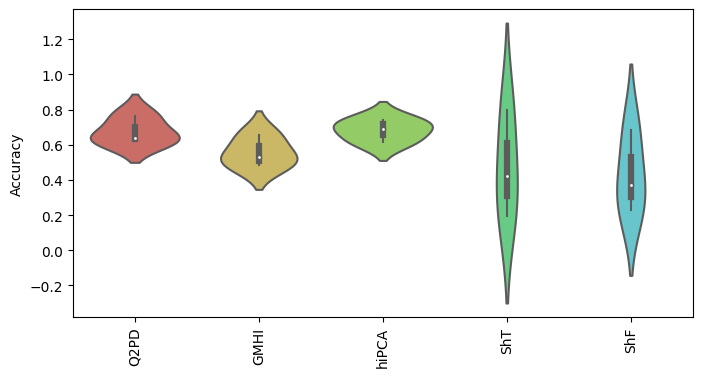

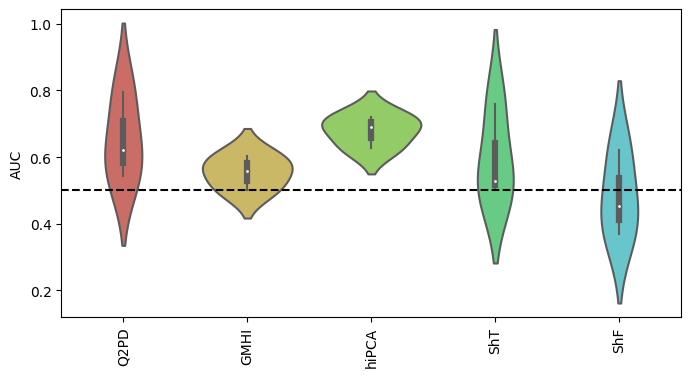

In [17]:
metrics_df = metrics_df.replace("Shannon Entropy on Functions","ShF")
metrics_df = metrics_df.replace("Shannon Entropy","ShT")

plt.figure(figsize=(8,4))
#sns.barplot(metrics_df, x='Method', y='Accuracy', palette=palette)
sns.violinplot(metrics_df, x='Method', y='Accuracy', palette=palette)
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8,4))
#sns.barplot(metrics_df, x='Method', y='AUC', palette=palette)
sns.violinplot(metrics_df, x='Method', y='AUC', palette=palette)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.xlabel("")
plt.xticks(rotation=90)
plt.show()

In [16]:
for a in list(set(list(scores['cohort']))):
    if a not in ['HMP2_IBD','HallAB_2017','NielsenHB_2014']:
        scores = scores.loc[scores['cohort'] != a]

In [17]:
print(scores.to_string())

                  category          cohort      GMHI      hiPCA  Shannon Entropy  Shannon Entropy on Functions  binary
ID                                                                                                                    
V1_UC1_0               IBD  NielsenHB_2014 -0.393208  -1.718805         3.125986                      5.109697       0
p9193_mo1              IBD     HallAB_2017 -0.321559  -1.118320         3.109914                      5.024748       0
MSM5LLIQ_P              UC        HMP2_IBD -2.994266  -0.718190         0.859936                      3.062451       0
V1_UC14_0              IBD  NielsenHB_2014  2.869670  -0.256516         3.033784                      4.765383       0
p9216_mo1              IBD     HallAB_2017 -0.827310  -3.592058         3.242801                      5.204204       0
O2_UC1_2               IBD  NielsenHB_2014 -0.098121  -3.132735         3.600963                      5.068029       0
O2_UC38_2              IBD  NielsenHB_2014 -3.49

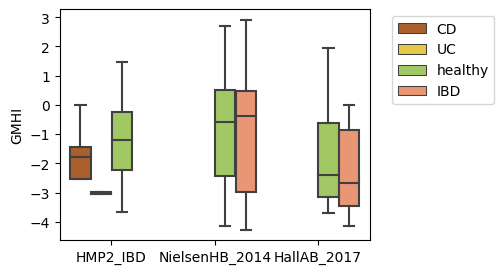

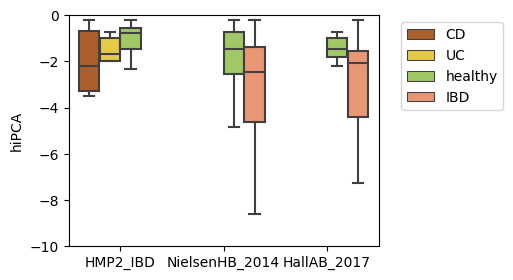

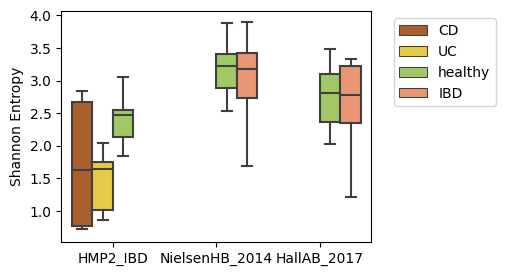

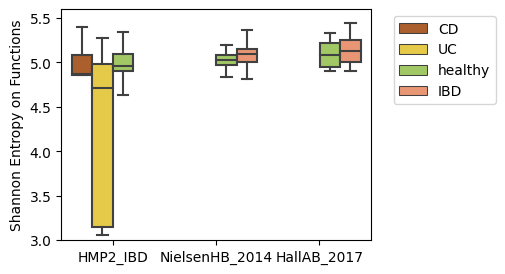

In [41]:
scores['sample_name'] = list(scores.index)

plt.figure(figsize=(4,3))
ax = sns.boxplot(scores.sort_values(by='sample_name'), x='cohort',y='GMHI', hue='category', palette=my_palette, fliersize=0)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(4,3))
ax = sns.boxplot(scores.sort_values(by='sample_name'), x='cohort',y='hiPCA', hue='category', palette=my_palette, fliersize=0)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim([-10,0])
plt.show()

plt.figure(figsize=(4,3))
ax = sns.boxplot(scores.sort_values(by='sample_name'), x='cohort',y='Shannon Entropy', hue='category', palette=my_palette, fliersize=0)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(4,3))
ax = sns.boxplot(scores.sort_values(by='sample_name'), x='cohort',y='Shannon Entropy on Functions', hue='category', palette=my_palette, fliersize=0)
plt.xlabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim([3,5.6])
plt.show()

In [19]:
merged_scores = pd.merge(scores, final_df, left_index=True, right_on='sample_name')
merged_scores = merged_scores[['predicted_probability', 'GMHI', 'hiPCA','Shannon Entropy', 'Shannon Entropy on Functions', 'binary','cohort_y']]
merged_scores.columns = ['Q2PD','GMHI', 'hiPCA', 'Shannon Entropy', 'Shannon Entropy on Functions','category', 'cohort']
print(merged_scores.columns)
print(merged_scores.head())

Index(['Q2PD', 'GMHI', 'hiPCA', 'Shannon Entropy',
       'Shannon Entropy on Functions', 'category', 'cohort'],
      dtype='object')
     Q2PD      GMHI     hiPCA  Shannon Entropy  Shannon Entropy on Functions  \
197  0.19 -0.393208 -1.718805         3.125986                      5.109697   
21   0.67 -0.321559 -1.118320         3.109914                      5.024748   
206  0.24  2.869670 -0.256516         3.033784                      4.765383   
22   0.46 -0.827310 -3.592058         3.242801                      5.204204   
59   0.43 -0.098121 -3.132735         3.600963                      5.068029   

     category          cohort  
197         0  NielsenHB_2014  
21          0     HallAB_2017  
206         0  NielsenHB_2014  
22          0     HallAB_2017  
59          0  NielsenHB_2014  


In [20]:
for cohort in list(merged_scores['cohort']):
    outname = "boruta_results/" + cohort + "_input.txt"
    sub = merged_scores.loc[merged_scores['cohort'] == cohort]
    sub.drop('cohort',axis=1).to_csv(outname, sep="\t", index=False)
    
#for f in $(ls boruta_results/*input.txt | cut -d "/" -f2 | sed 's/_input.txt//g') ; do /mnt/c/Program\ Files/R/R-4.3.3/bin/Rscript.exe 9_feature_importances_with_boruta.r ${f} ; done

In [21]:
# analyse boruta results

cohort_list = ['NielsenHB_2014','HallAB_2017','HMP2_IBD']
imp_df = pd.DataFrame(columns = ['Q2PD','GMHI','hiPCA','Shannon.Entropy','Shannon.Entropy.on.Functions','Cohort'])

for cohort in cohort_list:
    
    rank_name = "boruta_results/feature_ranking_" + cohort + ".csv"
    rank = pd.read_csv(rank_name, sep=",").iloc[:,:2]
    rank.columns = ['Index','meanIMP']
    rank = rank.sort_values(by='meanIMP', ascending=False)
    rank = rank.reset_index()
    rank['Rank'] = list(rank.index)
    rank['Rank'] = rank['Rank'] +1
    rank = rank.T
    rank.columns = list(rank.iloc[1])
    rank = rank.drop('Index')
    rank['Cohort'] = cohort
    rank = rank.iloc[-1].to_frame()
    imp_df = imp_df._append(rank.T)
    
imp_df.index = list(imp_df['Cohort'])
imp_df = imp_df.drop('Cohort', axis=1)
print(imp_df.to_string())

               Q2PD GMHI hiPCA Shannon.Entropy Shannon.Entropy.on.Functions
NielsenHB_2014    3    4     1               5                            2
HallAB_2017       2    4     1               3                            5
HMP2_IBD          1    4     3               2                            5


         Q2PD      GMHI     hiPCA       ShT       ShF
NaN  0.008222  0.001783   0.01633  0.001651  0.011206
NaN  0.020821 -0.003206  0.023467 -0.003108 -0.007876
NaN  0.062854  0.016386  0.032953  0.040619  0.004754


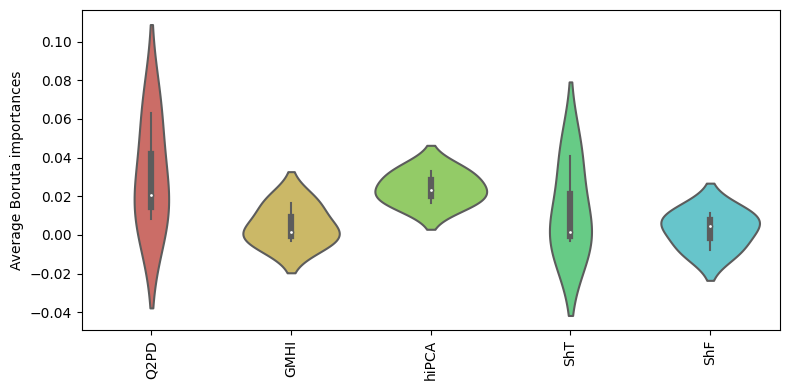

In [22]:
imp_df = pd.DataFrame(columns = ['Q2PD','GMHI','hiPCA','Shannon.Entropy','Shannon.Entropy.on.Functions','Cohort'])
for cohort in cohort_list:
    
    rank_name = "boruta_results/feature_ranking_" + cohort + ".csv"
    rank = pd.read_csv(rank_name, sep=",").iloc[:,:2]
    rank.columns = ['Index','meanIMP']
    rank = rank.sort_values(by='meanIMP', ascending=False)
    rank = rank.reset_index()
    rank = rank.T
    rank.columns = list(rank.iloc[1])
    rank = rank.drop(['Index','index'])
    imp_df = imp_df._append(rank)
   
imp_df.index = list(imp_df['Cohort'])
imp_df = imp_df.drop('Cohort', axis=1)
imp_df.columns = ['Q2PD','GMHI','hiPCA','ShT','ShF']
print(imp_df.to_string())

# Reshape the dataframe from wide to long format
df_melted = imp_df.melt(var_name='Columns', value_name='Values')
df_melted['Values'] = df_melted['Values'].astype(float)
# Create a seaborn barplot
plt.figure(figsize=(8,4)) #figsize=(10,6))
sns.violinplot(x='Columns', y='Values', data=df_melted, palette=palette)

# Display the plot
plt.xticks(rotation=90)  # Rotate x labels if needed
plt.ylabel("Average Boruta importances")
plt.xlabel("")
plt.tight_layout()
plt.show()

              0  Index
Q2PD   0.091898   Q2PD
GMHI   0.014964   GMHI
hiPCA  0.072749  hiPCA
ShT    0.039161    ShT
ShF    0.008084    ShF


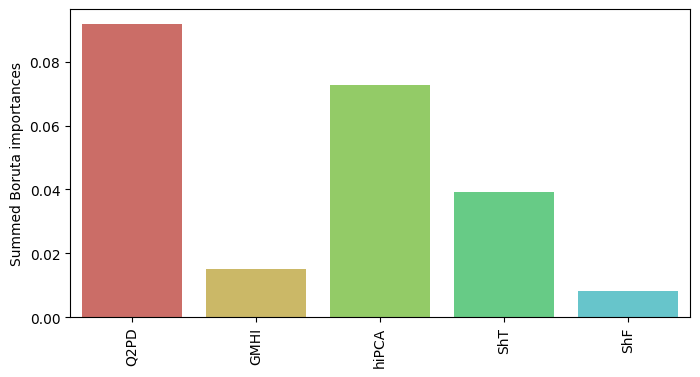

In [23]:
sub = imp_df.sum().to_frame()
sub['Index'] = list(sub.index)
sub = sub.replace("Shannon.Entropy.on.Functions","ShF")
sub = sub.replace("Shannon.Entropy","ShT")

print(sub)
plt.figure(figsize=(8,4))
sns.barplot(sub, x='Index',y=0, palette=palette)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel('Summed Boruta importances')
plt.show()